# Visualizing Soccer Data

#### Citations:

@Article{Hunter:2007,
  Author    = {Hunter, J. D.},
  Title     = {Matplotlib: A 2D graphics environment},
  Journal   = {Computing In Science \& Engineering},
  Volume    = {9},
  Number    = {3},
  Pages     = {90--95},
  abstract  = {Matplotlib is a 2D graphics package used for Python
  for application development, interactive scripting, and
  publication-quality image generation across user
  interfaces and operating systems.},
  publisher = {IEEE COMPUTER SOC},
  doi       = {10.1109/MCSE.2007.55},
  year      = 2007
}

#### Imports

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import random
from statsmodels.stats.proportion import proportions_ztest

#### Defines a soccer game

In [2]:
class Game:
    def __init__(self, homeTeam, awayTeam, homeScore, awayScore, date):
        self.homeTeam = homeTeam
        self.awayTeam = awayTeam
        self.homeScore = homeScore
        self.awayScore = awayScore
        self.date = date
        
        
    # Displays a game in the format Liverpool 4-3 Manchester City
    def display(self):
        print(self.homeTeam + " " + str(self.homeScore) + "-" +
             str(self.awayScore)+" "+self.awayTeam) 

#### Defines one matchweek

In [3]:
class Matchday:
    def __init__(self, number):
        self.number = number
        self.games = []
        
        
    # Adds a game to the list of games
    def addGame(self, game):
        self.games.append(game)

#### Defines a team's general stats over one season

In [4]:
class TeamSeason:
    def __init__(self, name):
        self.name = name
        self.points = 0
        self.scored = 0
        self.conceded = 0
        self.gD = 0
        self.place = 0
        
        
    # Adds info from one game to the data on a team's season-long performance
    def addGame(self, game):
        isHomeTeam = game.homeTeam == self.name
        
        # Assigning points for a draw
        if game.homeScore == game.awayScore:
            self.points += 1
            
        # Updating variables if home team
        if isHomeTeam:
            if game.homeScore > game.awayScore:
                self.points += 3
            self.scored += game.homeScore
            self.conceded += game.awayScore
        
        # Updating variables if away team
        else:
            if game.homeScore < game.awayScore:
                self.points += 3
            self.scored += game.awayScore
            self.conceded += game.homeScore
        self.gD = self.scored - self.conceded

#### Defines a class for an entire season

In [5]:
class Season:
    def __init__(self, year):
        self.year = year
        # A dictionary in the form of name: TeamSeason object
        self.teams = {}
        self.placed = []
        self.matchDays = []
        
    # adds to a list of individual weeks
    def addMatchDays(self, matchDay):
        self.matchDays.append(matchDay)
        
    # adds a team to the dictionary of teams
    def addTeam(self, name):
        if not name in self.teams:
            self.teams[name] = TeamSeason(name)
            
    # Given two teams, it compares them using official EPL procedures
    # Return 1 if teamA is better than team B, -1 if not
    def compareTeams(self, teamA, teamB):
        if teamA.points > teamB.points:
            return 1
        elif teamA.points == teamB.points:
            if teamA.gD > teamB.gD:
                return 1
            elif teamB.gD == teamB.gD:
                if teamA.scored > teamB.scored:
                    return 1
                elif teamB.scored == teamB.scored:
                    if teamA.name > teamB.name:
                        return 1
                    else:
                        return -1
                else:
                    return -1
            else:
                return -1
        else:
            return -1
        
    # Orders the teams based on comparisons
    def place(self):
        for team in self.teams:
            for i in range(len(self.teams)):
                try:
                    if self.compareTeams(self.teams[team], self.placed[i]) > 0:
                        self.placed.insert(i, self.teams[team])
                        break
                except IndexError:
                    self.placed.append(self.teams[team])
                    break
        for i in range(len(self.teams)):
            self.placed[i].place = i+1
            
    # Prints a simple epl table
    def table(self):
        for i in range(len(self.teams)):
            try:
                print(str(i+1) + " " + self.placed[i].name)
            except IndexError:
                print("Not Yet")

#### Creates arrays of seasons for four different leagues over several seasons

In [6]:
# Function that, when given Matchday 12 or 3-Matchday, or something like that, will return 12 or 3
def extractNumbers(matchdayName):
    numString = ""
    for i in matchdayName:
        try:
            numString += str(int(i))
        except ValueError:
            x = 1
    try:
        return int(numString)
    except ValueError:
        return 0


# Function to create a new season based on a json file
def newSeason(fileName):
    # Open data from file
    with open(fileName, "r") as read_file:
        data = json.load(read_file)
    # Name the new season:
    season = Season(data['name'])
    
    # Iterating through all sets of games
    for matchDay in data['rounds']:
        # Creating a matchday object
        if extractNumbers(matchDay['name']) == 0:
            break
        oneRound = Matchday(extractNumbers(matchDay['name']))
        # Iterating through each match
        for match in matchDay["matches"]:
            # On the first round, record the team names
            if oneRound.number == 1:
                season.addTeam(match['team1']['name'])
                season.addTeam(match['team2']['name'])
            # Attempt to create game object and add it to teamSeasons and one round
            try:
                game = Game(match['team1']['name'], match['team2']['name'],
                            int(match['score1']), int(match['score2']), match['date'])
                oneRound.addGame(game)
                season.teams[game.homeTeam].addGame(game)
                season.teams[game.awayTeam].addGame(game)
            # TypeError occurs when game was cancelled and scores are null
            except TypeError:
                x = 1
        # Adding a round of matches to the season
        season.addMatchDays(oneRound)
    # Determine final places in a season
    season.place()
    return season


# Function to create a list of seasons for each country
def makeSeasons(startYear, endYear, country):
    seasons = []
    for i in range(endYear - startYear):
        seasonName = "data/" + str(startYear+i) + "-" + str(startYear+i+1)[-2:] + "/" + country + ".1.json"
        season = newSeason(seasonName)
        seasons.append(season)
    return seasons

# Taking all possible data from the different leagues
eng = makeSeasons(2012, 2017, "en")
spn = makeSeasons(2012, 2017, "es")
ity = makeSeasons(2013, 2017, "it")
deu = makeSeasons(2012, 2017, "de")
aus = makeSeasons(2012, 2017, "at")

# Making a dictionary combining the data
leagues = {"England": eng, "Espana": spn, "Italia": ity,
           "deutschland": deu, "Osterreich": aus}

#### Functions for visualizing data

LSRL: y = 26.193536465796807 + -0.3029640244362318x
r^2: 0.7320339766378002


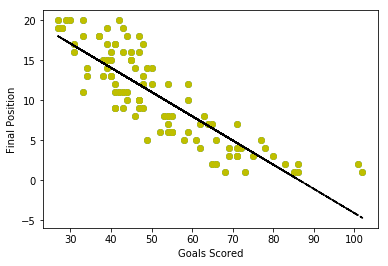

In [7]:
# Function taking in a list of seasons, outputting final place vs goals scored
def plotScoredPlace(seasons):
    scored = []
    finalPlace = []
    for season in seasons:
        for key, team in season.teams.items():
            scored.append(team.scored)
            finalPlace.append(team.place)
    plt.scatter(scored,finalPlace)
    plt.xlabel("Goals Scored")
    plt.ylabel("Final Position")
    slope, intercept, r_value, p_value, std_err = stats.linregress(scored,finalPlace)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(scored,finalPlace, 'yo', scored, fit_fn(scored), '--k')

    
# Function taking in a list of seasons, outputting final place vs goals conceded
def plotConcededPlace(seasons):
    conceded = []
    finalPlace = []
    for season in seasons:
        for key, team in season.teams.items():
            conceded.append(team.conceded)
            finalPlace.append(team.place)
    plt.scatter(conceded,finalPlace, color="red")
    plt.xlabel("Goals Conceded")
    plt.ylabel("Final Position")
    slope, intercept, r_value, p_value, std_err = stats.linregress(conceded,finalPlace)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(conceded,finalPlace, 'yo', conceded, fit_fn(conceded), '--k')

    
def plotConcededScored(seasons):
    conceded = []
    scored = []
    for season in seasons:
        for key, team in season.teams.items():
            conceded.append(team.conceded)
            scored.append(team.scored)
    plt.scatter(conceded,scored)
    plt.xlabel("Goals Conceded")
    plt.ylabel("Goals Scored")
    slope, intercept, r_value, p_value, std_err = stats.linregress(conceded,scored)
    print("LSRL: y = "+str(intercept)+" + "+str(slope)+"x")
    print("r^2: " + str(r_value ** 2))
    fit_fn = np.poly1d([slope, intercept]) 
    plt.plot(conceded,scored, 'yo', conceded, fit_fn(conceded), '--k')
 

def plotHomeWins(seasons):
    homeWins = 0
    awayWins = 0
    total = 0
    for season in seasons:
        for matchday in season.matchDays:
            for game in matchday.games:
                # Ensuring random sampling
                if random.randint(0, 2) == 0:
                    x = 1
                elif game.homeScore > game.awayScore:
                    homeWins += 1
                    total += 1
                elif game.homeScore < game.awayScore:
                    awayWins += 1
                    total += 1
    homePercentage = homeWins / total
    awayPercentage = awayWins / total
    x = np.arange(2)
    plt.bar(x, [homePercentage, awayPercentage])
    plt.xticks(x, ('Home Win Percentage', 'Away Win Percentage'))

                

plotScoredPlace(eng)
#plotConcededPlace(eng)
#plotConcededScored(eng)

    
            

#### Statistical Tests

4


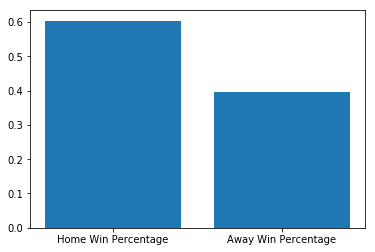

In [9]:
def oneProportionZTestHomeWins(seasons):
    homeWins = 0
    awayWins = 0
    total = 0
    matchTotal = 0
    for season in seasons:
        for matchday in season.matchDays:
            for game in matchday.games:
                # Ensuring random sampling
                if not random.randint(0, 11) == 0:
                    x = 1
                    matchTotal += 1
                elif game.homeScore > game.awayScore:
                    homeWins += 1
                    total += 1
                    matchTotal += 1
                elif game.homeScore < game.awayScore:
                    awayWins += 1
                    total += 1
                    matchTotal += 1
    homePercentage = homeWins / total
    awayPercentage = awayWins / total
    
    if homePercentage * total < 10 or awayPercentage * total < 10 or total < 30 or total / matchTotal > .1:
        print("Conditions not met")
        return 1
    stat, pval = proportions_ztest(homeWins, total, .5, "larger")
    #print("P-value: "+ str(pval))
    return pval

errors = 0
for i in range(1000):
    pval = oneProportionZTestHomeWins(eng+spn+ity+deu+aus)
    if pval > .01:
        errors += 1
print(errors)
plotHomeWins(eng)